# Overview of the `poligrain` package

In [1]:
import sys

sys.path.append('poligrain/src')

In [3]:
import matplotlib.pyplot as plt
import poligrain as plg

## Get OpenMRG example data

<img src="https://essd.copernicus.org/articles/14/5411/2022/essd-14-5411-2022-f02-web.png" alt="drawing" width="300"/>


We download a subset of the OpenMRG dataset which is described in Andersson et al. (2022) here https://doi.org/10.5194/essd-14-5411-2022 and which is available for download at https://doi.org/10.5281/zenodo.6673750

The subset that we use was already processed, in particular the CML data, but with a very basic processing.

In addition, here, we will project the lon-lat coordinates in the fitting UTM zone, so that we can do correct distance calculations.

In [4]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data")

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


### Project coordinates to UTM

In [5]:
# Project coordinates for rain gauges
ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, "EPSG:25832"
)
ds_gauge_smhi.coords["x"], ds_gauge_smhi.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauge_smhi.lon, ds_gauge_smhi.lat, "EPSG:25832"
)

# Project coordinates for CMLs
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, "EPSG:25832"
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, "EPSG:25832"
)

## Intro to data model

In OPENSENSE we agreed on a specific structure and naming convention for storing data in NetCDF, which translates to the respective `xarray.Dataset` objects.

### CML data

In [6]:
ds_cmls

<xarray.Dataset> Size: 1GB
Dimensions:       (sublink_id: 2, cml_id: 364, time: 69120)
Coordinates: (12/14)
  * sublink_id    (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time          (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T23:59:50
    site_0_lat    (cml_id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 3kB 57.7 57.72 57.69 ... 57.66 57.63 57.71
    ...            ...
    polarization  (sublink_id, cml_id) <U1 3kB ...
    length        (cml_id) float64 3kB ...
    site_0_x      (cml_id) float64 3kB 6.785e+05 6.776e+05 ... 6.792e+05
    site_0_y      (cml_id) float64 3kB 6.4e+06 6.402e+06 ... 6.394e+06 6.4e+06
    site_1_x      (cml_id) float64 3kB 6.783e+05 6.77e+05 ... 6.778e+05
    site_1_y      (cml_id) float64 3kB 6.399e+06 6.402e+06 ... 6.401e+06
Data variables:
    tsl           (time, sublink_id, cml_id) float64 403MB ...
    rsl           (time, sublink_id, cml_id) float64 403MB ...
    R             (sublink_id, cml_id, time) float64 403MB ...
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

### Gauge data

In [7]:
ds_gauges_municp

<xarray.Dataset> Size: 1MB
Dimensions:          (id: 10, time: 11520)
Coordinates:
  * id               (id) <U6 240B 'Jarn' 'Torp' 'Bergsj' ... 'Lbom' 'Askim'
  * time             (time) datetime64[ns] 92kB 2015-07-22 ... 2015-07-29T23:...
    lon              (id) float64 80B 11.94 12.04 12.07 ... 11.99 11.97 11.94
    lat              (id) float64 80B 57.65 57.72 57.75 ... 57.71 57.71 57.63
    location         (id) <U16 640B ...
    type             (id) <U14 560B ...
    quantization     (id) float64 80B ...
    x                (id) float64 80B 6.756e+05 6.808e+05 ... 6.757e+05
    y                (id) float64 80B 6.393e+06 6.401e+06 ... 6.392e+06
Data variables:
    rainfall_amount  (id, time) float64 922kB ...

###  Radar data (on cartesian grid)

In [8]:
ds_rad

<xarray.Dataset> Size: 33MB
Dimensions:  (time: 2304, x: 37, y: 48)
Coordinates:
  * time     (time) datetime64[ns] 18kB 2015-07-22 ... 2015-07-29T23:55:00
  * x        (x) float64 296B -1.542e+05 -1.522e+05 ... -8.42e+04 -8.22e+04
  * y        (y) float64 384B -3.413e+06 -3.415e+06 ... -3.505e+06 -3.507e+06
    lat      (y, x) float64 14kB ...
    lon      (y, x) float64 14kB ...
Data variables:
    crs      int32 4B ...
    R        (time, y, x) float64 33MB ...
Attributes:
    source:       Swedish Meteorological and Hydrological Institute (SMHI), H...
    contact:      hydro.fou@smhi.se, remco.vandebeek@smhi.se
    title:        OpenMRG-Radar
    license:      https://creativecommons.org/licenses/by-sa/4.0
    version:      1.1
    doi:          https://doi.org/10.5281/zenodo.6673750
    proj_string:  +proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90
    comment:      Created by Remco van de Beek, Victor Näslund and Johan Thur...

## Quick look at CML data

Look at RSL, TSL and R of a specific CML

(0.0, 5.0)

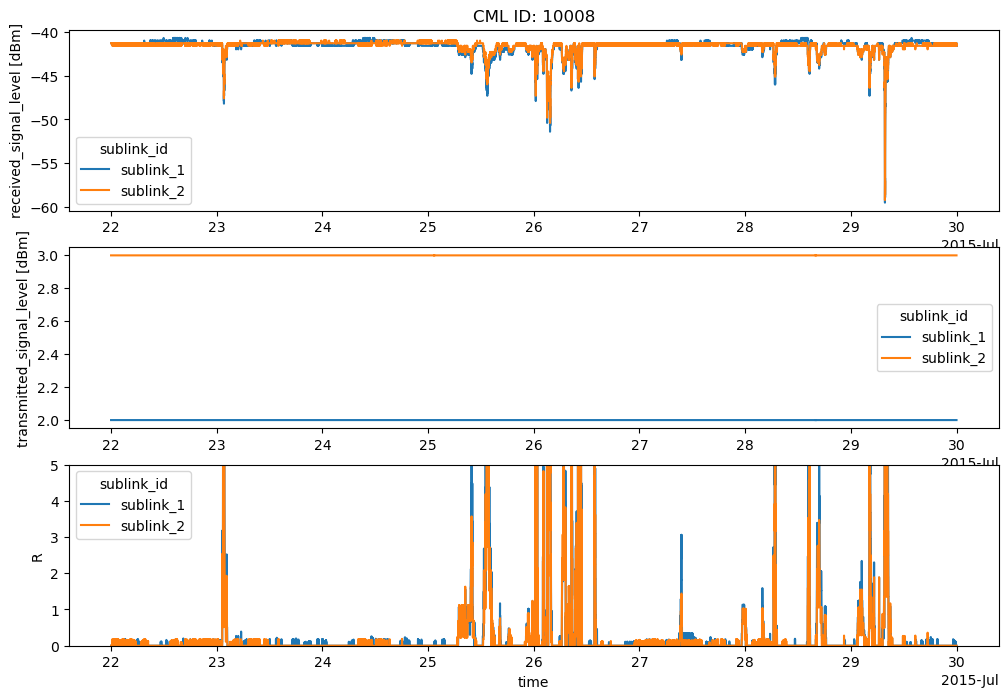

In [13]:
i = 7

fig, axs = plt.subplots(3, 1, figsize=(12, 8))
ds_cmls.isel(cml_id=i).rsl.plot.line(x='time', ax=axs[0])
ds_cmls.isel(cml_id=i).tsl.plot.line(x='time', ax=axs[1])
ds_cmls.isel(cml_id=i).R.plot.line(x='time', ax=axs[2])
[ax.set_title('') for ax in axs]
axs[0].set_title(f'CML ID: {ds_cmls.isel(cml_id=i).cml_id.data}')
axs[0].set_xlabel('')
axs[1].set_xlabel('');
axs[2].set_ylim(0, 5)

## Excercise 1: Look at data from different CMLs

Reuse the plot from above and test with selecting different CMLs

Questions:
- What do you observe?
- Also look closely at the small rain rates values. Hint: You can change the y-scale of the rain rate plot with `axs[2].set_ylim(0, 5)`

## Plot hourly rainfall sums for all CMLs

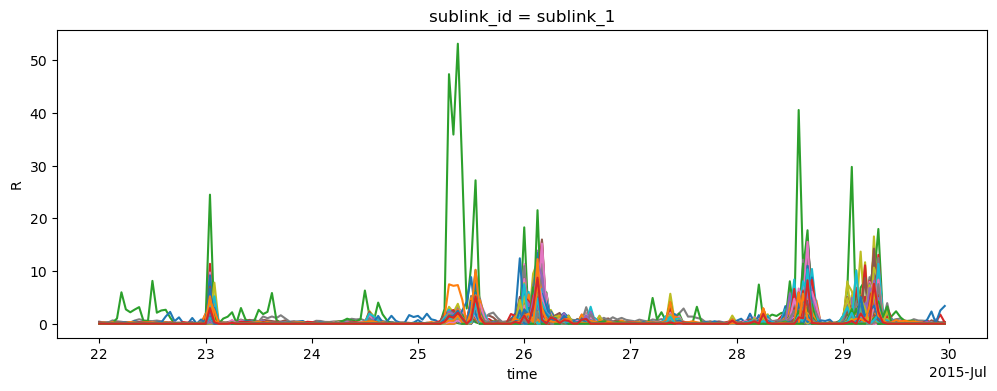

In [14]:
da_R = ds_cmls.R.isel(sublink_id=0)#
da_R.resample(time='1h').mean().plot.line(x='time', add_legend=False, figsize=(12, 4));

## Plot data on a map

Because plotting lines with a colormap is not as easy as plotting points or gridded data, `poligrain` provides plotting functions that deal with the line geometry. Because we assume a fixed structure and naming convention of our `xarray.Dataset` we can do a lot of cumbersome stuff inside the function. See it in action below.

CML rain rates for a selected time stamp

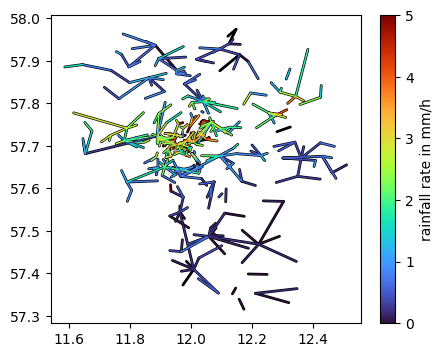

In [15]:
da_R = ds_cmls.R.isel(sublink_id=0).sel(time='2015-07-25 10:00:00')

fig, ax = plt.subplots(figsize=(5, 4))
lines = da_R.plg.plot_cmls(pad_width=1, vmin=0, vmax=5, ax=ax, use_lon_lat=True)
plt.colorbar(lines, label="rainfall rate in mm/h");

Rainfall sums over full period for radar, CMLs and gauges

<Axes: xlabel='lon', ylabel='lat'>

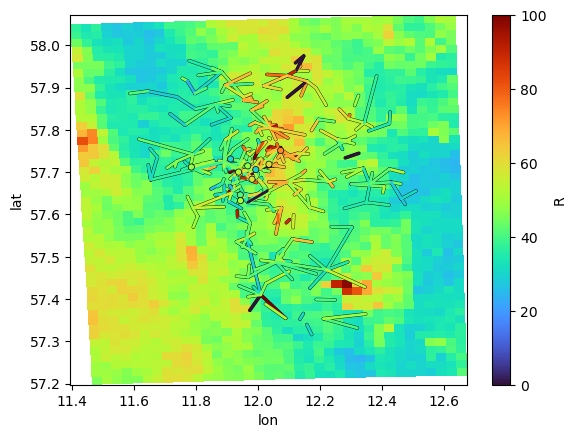

In [16]:
plg.plot_map.plot_plg(
    da_grid=ds_rad.R.resample(time='1h').mean().sum(dim="time"),
    da_gauges=ds_gauges_municp.rainfall_amount.sum(dim="time"),
    use_lon_lat=True,
    da_cmls=ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().sum(dim="time"),
    vmin=0,
    vmax=100,
)

## Extract radar along CML paths and compare data

Similar to the `wradlib.adjust.RawAtObs` we provide functions to get data of a grid at specific points using `plg.spatial.GridAtPoints`. Since we also deal with line geometries of the CMLs (and also SMls) we provide `GridAtLines` to extract the path-averaged grid values along the intersection with a specific line.

In [17]:
get_grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_rad,
    ds_line_data=ds_cmls,
)

In [18]:
radar_along_cml = get_grid_at_lines(da_gridded_data=ds_rad.R)

In [19]:
radar_along_cml

<xarray.DataArray (time: 2304, cml_id: 364)> Size: 7MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * cml_id      (cml_id) int64 3kB 10001 10002 10003 10004 ... 10362 10363 10364
  * time        (time) datetime64[ns] 18kB 2015-07-22 ... 2015-07-29T23:55:00
    site_0_lat  (cml_id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon  (cml_id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat  (cml_id) float64 3kB 57.7 57.72 57.69 57.7 ... 57.66 57.63 57.71
    site_1_lon  (cml_id) float64 3kB 11.99 11.97 11.98 ... 12.14 11.97 11.98
    length      (cml_id) float64 3kB ...
    site_0_x    (cml_id) float64 3kB 6.785e+05 6.776e+05 ... 6.808e+05 6.792e+05
    site_0_y    (cml_id) float64 3kB 6.4e+06 6.402e+06 ... 6.394e+06 6.4e+06
    site_1_x    (cml_id) float64 3kB 6.783e+05 6.77e+05 ... 6.772e+05 6.778e+05
    site_1_y    (cml_id) float64 3kB 6.399e+06 6.402e+06 ... 6.391e+06 6.401e+06

Aggregate to hourly rainfall for comparison

In [20]:
radar_along_cml_R_1h = radar_along_cml.resample(time='1h').mean()
cmls_R_1h = ds_cmls.R.isel(sublink_id=0).resample(time='1h').mean()

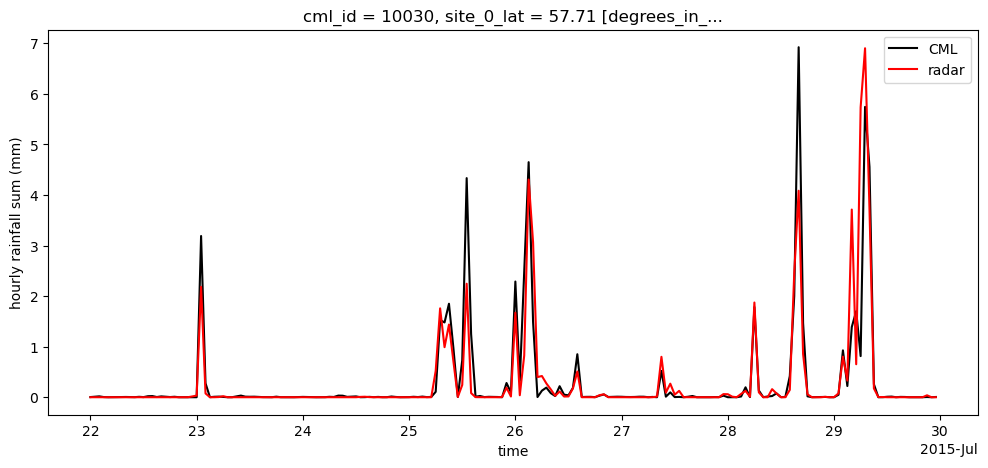

In [21]:
cml_id = 10030

cmls_R_1h.sel(cml_id=cml_id).plot(color='k', figsize=(12, 5), label='CML')
radar_along_cml_R_1h.sel(cml_id=cml_id).plot(color='r', label='radar')
plt.legend()
plt.ylabel('hourly rainfall sum (mm)');

Plot path-averaged radar rain rates for each CML and the processed CML rain rates

<Axes: >

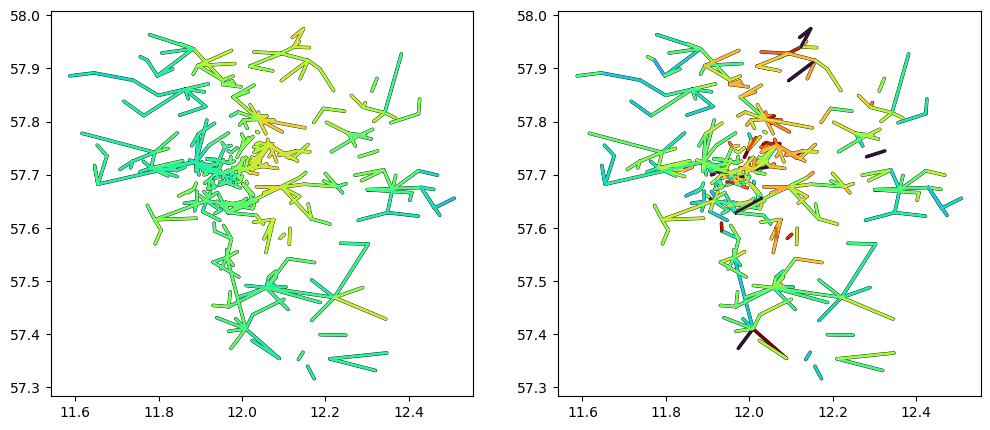

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plg.plot_map.plot_plg(
    da_cmls=radar_along_cml_R_1h.sum(dim='time'), 
    ax=axs[0], 
    vmin=0, 
    vmax=100,
)
plg.plot_map.plot_plg(
    da_cmls=cmls_R_1h.sum(dim='time'), 
    ax=axs[1],
    vmin=0,
    vmax=100,
)

## Excercise 2: Analyse difference between radar and CML

- 2.1: Do a scatter plot (`plt.scatter`) of the total rainfall sums for both radar and CML data. What do you observe?

- 2.2: Calculate the difference between radar and CML rainfall sums. Plot this difference as a map using `plg.plot_map.plot_plg`

- 2.3 (optional): What is wrong with the outliers of the CMLs?

### Exercise 2.1

In [23]:
# Write code here...






Text(0, 0.5, 'CML rainfall sum (mm)')

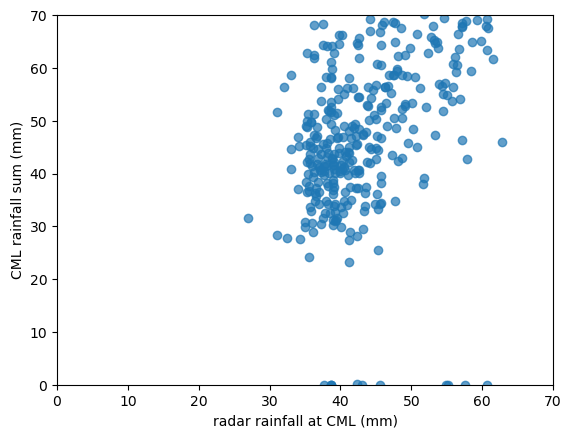

In [25]:
# %load solutions/1_2_1_solution.py
radar_along_cml_R_sum = radar_along_cml_R_1h.sum(dim='time')
cmls_R_sum = cmls_R_1h.sum(dim='time')

plt.scatter(radar_along_cml_R_sum, cmls_R_sum, alpha=0.7)
plt.xlim([0, 70])
plt.ylim([0, 70])
plt.xlabel('radar rainfall at CML (mm)')
plt.ylabel('CML rainfall sum (mm)')

### Exercise 2.2

In [26]:
# Write code here...







<Axes: >

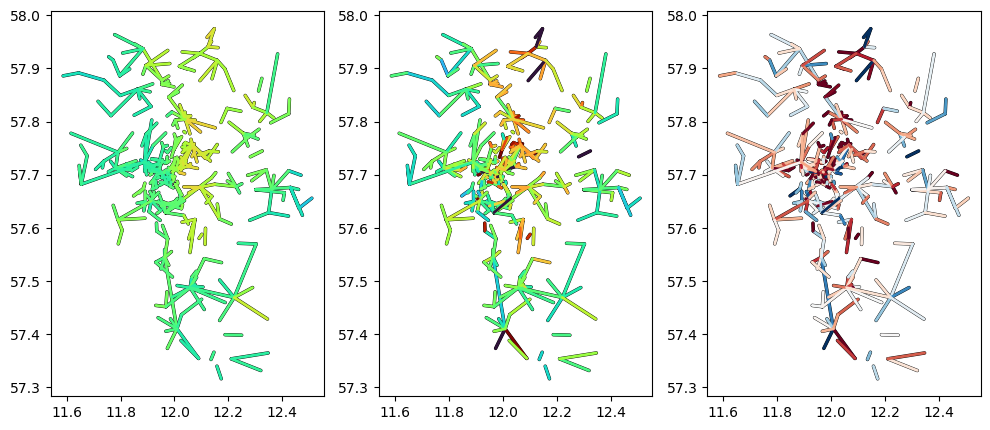

In [28]:
# %load solutions/1_2_2_solution.py
da_diff = radar_along_cml_R_sum - cmls_R_sum

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
plg.plot_map.plot_plg(da_cmls=radar_along_cml_R_sum, ax=axs[0], vmin=0, vmax=100)
plg.plot_map.plot_plg(da_cmls=cmls_R_sum, ax=axs[1], vmin=0, vmax=100)
plg.plot_map.plot_plg(da_cmls=da_diff, ax=axs[2], vmin=-20, vmax=20, cmap='RdBu')

### Exercise 2.3

In [ ]:
# Write code here...







In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load solutions/1_2_3_solution.py

## Find gauges close to CMLs and compare data

`poligrain` provides functions to find the closest points (gauges in this case) to a line (CMLs). Getting closest points for a point is also supported via `plg.spatial.get_closest_points_to_point`.

In [ ]:
max_distance = 2000  # in meters due to the projection EPSG:25832
closest_neigbors = plg.spatial.get_closest_points_to_line(
    ds_cmls, ds_gauges_municp, max_distance=max_distance, n_closest=10
)

In [ ]:
closest_neigbors

Plot distance of closest neighour for some CMLs

In [ ]:
closest_neigbors.isel(cml_id=slice(0, 60)).distance.plot();

Plot closest gauges for a CML on the map

In [ ]:
# plot CMLs and gauges on map and highlight those that are closer than 5000m
cml_id = 10030

# hacky way to get bool array with closest gauges set to True
da_gauges_close = (ds_gauges_municp.id == closest_neigbors.neighbor_id.sel(cml_id=cml_id)).max(dim='n_closest')

fig, ax = plt.subplots()
plg.plot_map.plot_lines(ds_cmls, line_color='k', ax=ax)
plg.plot_map.plot_lines(ds_cmls.sel(cml_id=cml_id), line_color='r', line_width=2, ax=ax)
# hacky way to plot the gauges highligting the close ones
plg.plot_map.plot_plg(da_gauges=da_gauges_close, ax=ax, vmin=0, vmax=2, cmap='Reds')


Plot rainfall time series for CML and closest gauges

In [ ]:
cml_id = 10030
ds_closests_gauges = (
    ds_gauges_municp.sel(id=closest_neigbors.sel(cml_id=cml_id).neighbor_id.values[:3])
)
ds_closests_gauges.rainfall_amount.resample(time='1h').sum().plot.line(x='time', figsize=(12, 5))
ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id).R.resample(time='1h').mean().plot(color='k')
plt.ylabel('hourly rainfall sum (mm)');

Let's zoom in and plot the data with the original temporal resolution

In [ ]:
cml_id = 10030
ds_closests_gauges = (
    ds_gauges_municp.sel(id=closest_neigbors.sel(cml_id=cml_id).neighbor_id.values[:3])
)
(ds_closests_gauges.sel(time='2015-07-25').rainfall_amount * 60).plot.line(x='time', figsize=(12, 5))
ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id, time='2015-07-25').R.plot(color='k')
plt.ylabel('rain rate (mm/h)');

If we aggregate the gauge to 5-minute rain rates we some more dynamics in the gauge data.

In [ ]:
cml_id = 10030
ds_closests_gauges = (
    ds_gauges_municp.sel(id=closest_neigbors.sel(cml_id=cml_id).neighbor_id.values[:3])
)
(ds_closests_gauges.sel(time='2015-07-25').rainfall_amount.resample(time='5min').sum() * 12).plot.line(x='time', figsize=(12, 5))
ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id, time='2015-07-25').R.plot(color='k')
plt.ylabel('rain rate (mm/h)');

## Excercise 3 (optional): Compare CML to gauges within 2 km

- Exercise 3.1: Do a scatter plot of of the 1-hour rainfall amounts from the closest gauge to each CML.

- Exercise 3.2: Add the radar at the CML to the scatter plot

The following code gives you, for each CML, the ID of the closest gauge if there is a gauge within 2 km range from the CML path.

Note that CMLs with no gauge withon 2km have been dropped here. Hence, the length of `gauge_id_closest` and `closest_neigbors` is different in the `cml_id` dimension.

In [ ]:
gauge_id_closest = closest_neigbors.neighbor_id.where(closest_neigbors.distance < 2000, drop=True).isel(n_closest=0)
gauge_id_closest

### Exercise 3.1

In [ ]:
# Write code here...






In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load solutions/1_3_1_solution.py

In [ ]:
# Write code here...






In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load solutions/1_3_2_solution.py

## Validation metrics and plots

`poligrain` provides plots and the calculation of standard metrics for validating the results. In particular the options for validating rain event detection are quite unique (probably because this very important for CML data processing and less important for radars ans gauges).

In [ ]:
radar_along_cml_R_1h = radar_along_cml.resample(time='1h').mean().transpose()
R_cml_1h = ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean()

In [ ]:
R_threshold = 0.1

plg.validation.plot_hexbin(
    radar_along_cml_R_1h.data.flatten(),
    R_cml_1h.data.flatten(),
    ref_thresh=R_threshold,
    est_thresh=R_threshold,
)

In [ ]:
rainfall_metrics = plg.validation.calculate_rainfall_metrics(
    reference=radar_along_cml_R_1h.data.flatten(),
    estimate=R_cml_1h.data.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
)
rainfall_metrics

In [ ]:
plg.validation.plot_confusion_matrix_count(
    reference=radar_along_cml_R_1h.data.flatten(),
    estimate=R_cml_1h.data.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
    n_bins=1000,
    bin_type='linear',
);
#plt.gca().set_xscale("linear")
#plt.gca().set_yscale("log")
plt.xlim([0.09, 10])

In [ ]:
plg.validation.plot_confusion_matrix_sum(
    reference=radar_along_cml_R_1h.data.flatten(),
    estimate=R_cml_1h.data.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
    n_bins=1000,
    bin_type='linear',
    time_interval=60,
);
#plt.gca().set_xscale("linear")
#plt.gca().set_yscale("log")
plt.xlim([0.09, 10])

## Other example datasets

### OpenRainER

CML, gauge and radar data from Emiliga Romana (Italy)

Available at https://zenodo.org/records/14731404 

Some info from the OPENSENSE news page: https://opensenseaction.eu/news/new-open-cml-dataset-from-italy-openrainer/


<img src="https://opensenseaction.eu/wp-content/uploads/2024/03/OpenRainER.jpg" alt="drawing" width="600"/>


In [ ]:
(
    ds_rad,
    ds_cmls,
    ds_gauges
) = plg.example_data.load_openrainer(data_dir="example_data", subset='8d')

In [ ]:
plg.plot_map.plot_lines(ds_cmls.rsl.isel(sublink_id=0).std(dim='time'), vmin=0, vmax=5)

In [ ]:
ds_cmls.isel(cml_id=0).rsl.plot.line(x='time', figsize=(12, 3));

### Amsterdam PWS dataset

This is not yet availalbe via `poligrain`. You will use it in the PWS excercises, via a custom download and parsing process.